# Advanced Lane Line Finding


In [1]:
from importlib import reload
import utils; reload(utils)
import numpy as np
import glob
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
%matplotlib inline
import os

In [2]:
cal_dir = "camera_cal"
test_imgs_dir = "test_images"
out_imgs_dir = "output_images"
out_videos_dir = "output_videos"

### Get Test Images

In [3]:
test_img_paths = glob.glob(test_imgs_dir + "/*.jpg")
test_img_paths

['test_images/test6.jpg',
 'test_images/test5.jpg',
 'test_images/test4.jpg',
 'test_images/test1.jpg',
 'test_images/test3.jpg',
 'test_images/test2.jpg',
 'test_images/straight_lines2.jpg',
 'test_images/straight_lines1.jpg']

In [4]:
test_imgs = [utils.load_image(img) for img in test_img_paths]

In [5]:
def get_test_img_name(test_img_path):
    name_plus_ending = test_img_path.split('/')[1]
    name = name_plus_ending.split('.')[0]
    return name
    
test_img_names = [get_test_img_name(path) for path in test_img_paths]
test_img_names

['test6',
 'test5',
 'test4',
 'test1',
 'test3',
 'test2',
 'straight_lines2',
 'straight_lines1']

# Camera Calibration and Undistortion
Let's first get the paths of all our calibration images. Note, when loading images with imread, they get stored in BGR color format. When using imshow, however, we need them in RGB color format. Therefore, we create in utils.py a convenience function load_img that loads the image and converts into RGB color format.

In [6]:
cal_img_paths = glob.glob(cal_dir + "/*.jpg")
print(len(cal_img_paths))

20


There are 20 images in the calibration image directory. Let's now take a look at the first chessboard image to see what it looks like. 

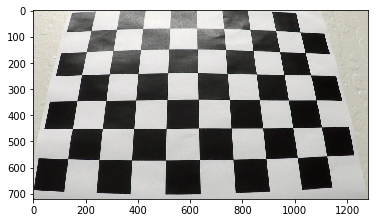

In [7]:
cal_img = utils.load_image(cal_img_paths[4])
plt.imshow(cal_img)

### Finding and Drawing Chessboard Corners

The Chessboard has 9x6 inner corners. We now use these parameters for the function `cv2.findChessboardCorners()`.

In [8]:
nx = 9
ny = 6

First of all, we feed the function a grayscaled image. 

In [9]:
gray = cv2.cvtColor(cal_img, cv2.COLOR_RGB2GRAY)

Now, we test the above functions with the first of the calibration images. 

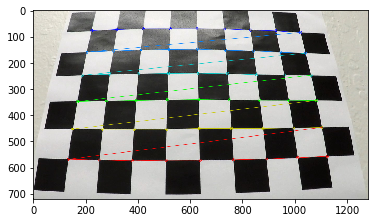

In [10]:
ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
if ret == True:
    cv2.drawChessboardCorners(cal_img, (nx, ny), corners, ret)
    plt.imshow(cal_img)

The corner detection seems to be working, however not for all calibration images. Some images are too small, i.e. not all corners are visible. Next, we will use the found corners to undistort the camera. 

## Camera Calibration
With the above functions, we now create the camera matrix and the distortion coefficients. Therefore, we first need to define image points and object points of the chessboard corners. 

### Find Image and Object Points
For distortion correction, we map the 2D chessboard corners in the image, the so-called image points, onto the 3D chessboard corners in the "real world", the so-called object points. We compute image- and object points from all calibration images in the calibration image path. 

In [57]:
def get_image_object_points(img_paths, nx, ny):
    
    # prepare object and image points
    obj_points = [] # 3D points in real world space
    img_points = [] # 2D points in image plane
    # Prepare object points, like (0, 0, 0), (1, 0, 0), (2, 0, 0),... , (8, 5, 0)
    obj_pts = np.zeros((nx * ny, 3), np.float32)
    obj_pts[:, :2] = np.mgrid[:nx, :ny].T.reshape(-1, 2)
    
    for img_path in img_paths:
        # read in image
        img = utils.load_image(img_path)
        # convert image to grayscale
        gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    
        if ret == True:
            img_points.append(corners)
            obj_points.append(obj_pts)
            
    return img_points, obj_points

The opencv function `calibrate camera` uses these image and object points to determine the camera matrix and the distortion coefficient. 

### Camera Calibration
We now create a camera calibration pipeline that takes in the calibration image path as well as the number of chessboard corners `nx` and `ny` and returns the camera matrix `mtx` and distortion `dist`.

In [41]:
def save_camera_coefficients(image_points, object_points, mtx, dst):
    with open('calibration_coefficients/mtx_dst', 'wb') as f:
        pickle.dump('mtx', f)
        pickle.dump('dist', f)
    with open('calibration_coefficients/img_obj_pts', 'wb') as f:
        pickle.dump('image_points', f)
        pickle.dump('object_points', f)

def calibrate_camera(img, cal_img_path, nx, ny):
    """Calibrates camera using one test image and the calibration images"""
    img_pts, obj_pts = get_image_object_points(cal_img_path, nx, ny)
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_pts, img_pts, gray.shape[::-1], None, None)
    save_camera_coefficients(img_pts, obj_pts, mtx, dist)
    return mtx, dist
    

We now calibrate our camera. For calibrating the camera, the function needs one test image, because it needs its shape for determining the camera matrix. 

In [42]:
mtx, dist = calibrate_camera(img=test_imgs[0], cal_img_path=cal_img_paths, nx=9, ny=6)
img_points, obj_points = get_image_object_points(cal_img_paths, nx=9, ny=6)

other way:

## Undistortion
First of all, we test our calibration and undistortion pipeline on a calibration image. The opencv function `cv2.undistort` uses the above `mtx` and `dist` to undistort images.

In [59]:
def undistort_img(img, mtx, dist):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

def cal_undistort(img, imgpoints, objpoints):
    """Alternative function for undistorting that calibrates mtx and dist every time"""
    # Use cv2.calibrateCamera() and cv2.undistort()
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist


First, we test the undistortion on a calibration image. 

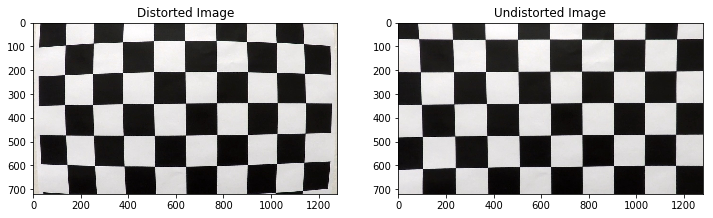

In [65]:
cal_img_example =utils.load_image(cal_img_paths[6])
cal_img_example_undistort = undistort_img(cal_img_example, mtx, dist)
fig, ax = plt.subplots(1, 2, figsize=(12, 14))
ax[0].imshow(cal_img_example)
ax[0].set_title('Distorted Image')
ax[1].imshow(cal_img_example_undistort)
ax[1].set_title('Undistorted Image')
plt.show()

This does works reasonably well, but not perfectly on all calibration images.

### Undistorting all test images


In [76]:
list(zip(undist_test_imgs, test_imgs))

[(array([[[116, 155, 196],
          [115, 154, 195],
          [115, 154, 195],
          ...,
          [ 97, 150, 192],
          [ 97, 150, 192],
          [ 97, 150, 192]],
  
         [[116, 155, 196],
          [116, 155, 196],
          [115, 154, 195],
          ...,
          [ 97, 150, 192],
          [ 97, 150, 192],
          [ 97, 150, 192]],
  
         [[116, 155, 196],
          [116, 155, 196],
          [116, 155, 196],
          ...,
          [ 97, 150, 192],
          [ 97, 150, 192],
          [ 97, 150, 192]],
  
         ...,
  
         [[ 90,  64,  65],
          [ 91,  65,  66],
          [ 91,  66,  67],
          ...,
          [127, 102,  95],
          [126, 101,  94],
          [124,  99,  92]],
  
         [[ 93,  69,  69],
          [ 93,  68,  69],
          [ 92,  68,  68],
          ...,
          [118,  93,  86],
          [121,  96,  89],
          [123,  98,  91]],
  
         [[ 95,  71,  71],
          [ 94,  70,  70],
          [ 95,  71,  71

IndexError: tuple index out of range

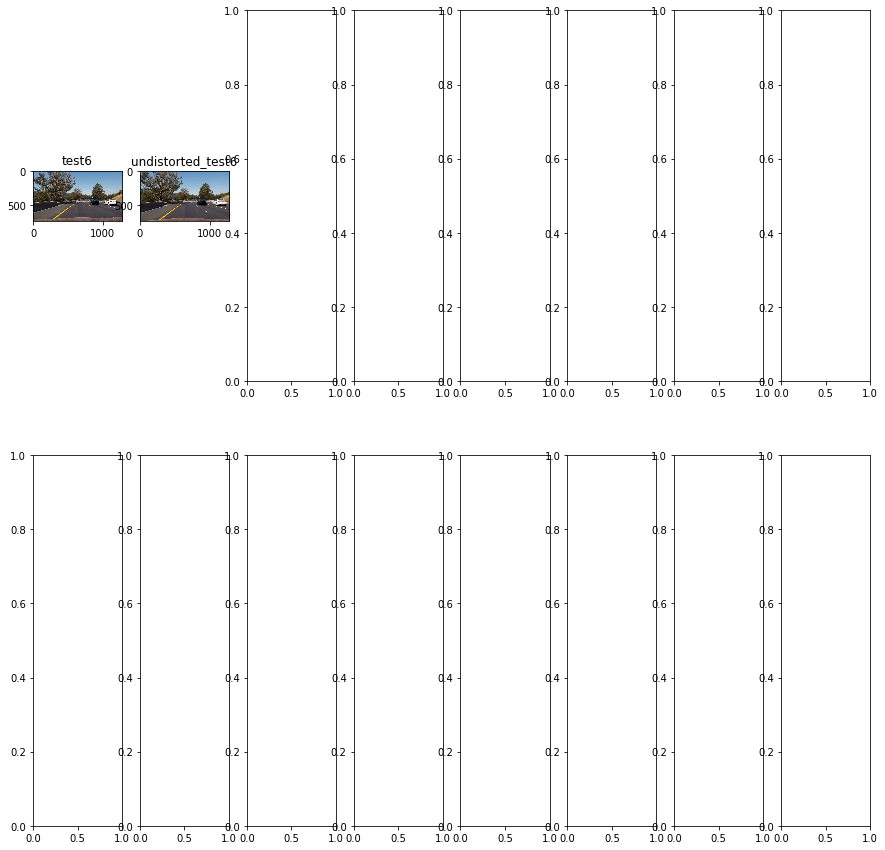

In [77]:
undist_test_imgs = [undistort_img(test_img, mtx, dist) for test_img in test_imgs]
undist_test_img_names = ['undistorted_' + test_img_name for test_img_name in test_img_names]
utils.show_img_lists(list(zip(test_imgs, undist_test_imgs)), image_names=list(zip(test_img_names, undist_test_img_names)), title=None, figsize=(15, 15))

# Thresholding
In order to find pixels that are likely to be part of a line, we apply  color thresholding as well as gradient thresholding in this section. This will make it easier to later find a polynomial that fits the lane lines well. 

## Gradient Thresholds
In the last exercise we used Canny edge detection to find possible lane lines in the image. Canny finds all possible lines in an image. Looking at lane lines, however, we have a smarter way for filtering pixels, because we know that the relevant lines are close to vertical. 